In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns

In [2]:
def getd(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma* np.sqrt(T)
    return d1, d2

def getDelta(S, K, T, r, sigma, d=0, flag='C'):
    N = norm.cdf
    d1, d2 = getd(S, K, T, r, sigma)
    
    if flag =='C':
        return N(d1)
    elif flag =='P':
        return N(d1) - 1
    
def getTheta(S, K, T, r, sigma, OptionDays=250, d=0, flag='C'):
    N = norm.cdf
    d1, d2 = getd(S, K, T, r, sigma)
    
    Nd1 = np.exp(-(d1**2)/2) / (np.sqrt(2 * np.pi))
    
    if flag =='C':
        return 1/OptionDays * -((S * sigma * Nd1) / (2 * np.sqrt(T)) - r * K * np.exp(-r * T) * N(d2))
    elif flag == 'P':
        return 1/OptionDays * -((S * sigma * Nd1) / (2 * np.sqrt(T)) + r * K * np.exp(-r * T) * (1 - N(d2)))
    
def getBSPrice(S, K, T, r, sigma, d=0, flag='C'):
    N = norm.cdf
    d1, d2 = getd(S, K, T, r, sigma)
    
    if flag == 'C':
        return S * N(d1) - K * np.exp(-r*T)* N(d2)
    elif flag == 'P':
        return K * np.exp(-r*T)* N(-d2) - S * N(-d1)
    
def getPayoff(S, K, flag='C'):
    if flag == 'C':
        return max(S-K, 0)
    elif flag == 'P':
        return max(K-S, 0)
    
def getSen(S, K, T, r, sigma, conv, tick=0.25, d=0, flag='C'):
    delta = getDelta(S, K, T, r, sigma, d, flag)
    return round((delta/conv) * (tick/0.01), 3)

def getGearing(S, K, T, r, sigma, conv, d=0, flag='C'):
    delta = getDelta(S, K, T, r, sigma, flag)
    Premium = getBSPrice(S, K, T, r, sigma, d, flag)
    return round(abs(delta) * (S/Premium), 3)

def getVega(S, K, T, r, sigma):
    N = norm.cdf
    d1, d2 = getd(S, K, T, r, sigma)
    Nd1 = np.exp(-(d1**2)/2) / (np.sqrt(2 * np.pi))
    return S * np.sqrt(T) * Nd1 * 0.01

def getGamma(S, K, T, r, sigma):
    d1, d2 = getd(S, K, T, r, sigma)
    Nd1 = np.exp(-(d1**2)/2) / (np.sqrt(2 * np.pi))
    return Nd1 / (S*sigma*np.sqrt(T))

In [3]:
def getGBM(S, T, mu, sigma, N, M):
    dt = T/N
    St = np.exp((mu - sigma ** 2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=(M,N)).T)
    St = np.vstack([np.ones(M), St])
    St = S * St.cumprod(axis=0)
    
    return St

In [14]:
## Input ##
DayinYr = 250

flag = 'C'
Moneyness = 0.25
S = 50.
T = 1.
K = S/(1 - Moneyness) if flag == 'C' else S * (1 - Moneyness)
# K = 200.
d = 0.

r = 0.02
mu = 0.1
sigma = 0.4
# sigma = 0.1645
N = round(21 * 3.5)
# N = 103
M = 5000

PricingVol = sigma * 1.3
tick = 0.1
conv = 2.5
Multiplier = 1/conv
Notional = 1000000
Outstanding = 1.

In [15]:
round(PricingVol, 2)

0.52

In [16]:
## Calculate Notional ##
DWUnit = -(Notional / (Multiplier * S))
# DWUnit = Notional * Outstanding
ULUnit = abs(DWUnit) * Multiplier
print(f'UL Unit: {round(ULUnit)}')
print(f'DW Unit: {round(DWUnit)}')

## Calculate Specification ##
Premium = getBSPrice(S, K, N/DayinYr, r, PricingVol, d, flag) / conv
DWSen = getSen(S, K, N/DayinYr, r, PricingVol, conv, tick, d, flag)
DWGear = getGearing(S, K, N/DayinYr, r, PricingVol, conv, d, flag)
DWDelta = getDelta(S, K, N/DayinYr, r, PricingVol, d, flag)
DWTheta = getTheta(S, K, N/DayinYr, r, PricingVol, 250, d, flag)

print(f'DW Premium: {round(Premium, 2)}')
print(f'TTM (Days): {N}')
print(f'Sensitivity: {DWSen}')
print(f'Effective Gearing: {DWGear}')
print(f'Delta: {round(DWDelta, 4)}')
print(f'Theta (%): {round(DWTheta / Premium * conv, 4)}')
print(f'Theta (Baht): {round(DWTheta, 4)}')

UL Unit: 20000
DW Unit: -50000
DW Premium: 0.54
TTM (Days): 74
Sensitivity: 0.786
Effective Gearing: 7.228
Delta: 0.1964
Theta (%): -0.1186
Theta (Baht): -0.0258


In [17]:
## Simulate Price Path ##
St = getGBM(S, T/DayinYr, mu, sigma, N, M)
St

array([[50.        , 50.        , 50.        , ..., 50.        ,
        50.        , 50.        ],
       [50.10009363, 49.58705843, 49.88526705, ..., 50.00235766,
        50.01743955, 49.85026206],
       [50.27872443, 49.49967062, 49.77752213, ..., 50.17000683,
        50.05733832, 50.02000462],
       ...,
       [50.05833919, 48.40759757, 49.65942256, ..., 49.05499725,
        50.28751262, 49.97152063],
       [50.04038523, 48.38803645, 49.83982642, ..., 49.14821888,
        50.31298429, 49.94695748],
       [50.22774883, 48.44092233, 49.8736545 , ..., 49.04382447,
        50.20318944, 49.79290874]])

In [1032]:
## Calculate DW price and Greeks ##
DWPrice = np.zeros((N, M))
Delta = np.zeros((N, M))
Gamma = np.zeros((N, M))
Vega = np.zeros((N, M))
Theta = np.zeros((N, M))

for n in range(N):
    ttm = (N-n) / DayinYr
    DWPrice[n,:] = getBSPrice(St[n,:], K, ttm, r, PricingVol, d, flag) / conv
    Delta[n,:] =  getDelta(St[n,:], K, ttm, r, sigma, d, flag)
    Gamma[n,:] = getGamma(St[n,:], K, ttm, r, sigma)
    Vega[n,:] = getVega(St[n,:], K, ttm, r, sigma)
    Theta[n,:] = getTheta(St[n,:], K, ttm, r, sigma, 250, d, flag)

DWPrice[-1,:] = 0

In [1033]:
## Calculate P/L ##
DWPosition = np.zeros((N, M))
DWPosition.fill(DWUnit)
DWPosition[-1,:] = 0

DWTrade = np.zeros((N, M))
DWTrade.fill(0)
DWTrade[0,:] = DWUnit
DWTrade[-1,:] = DWUnit * -1

HedgeRe = np.zeros((N, M))
HedgeTr = np.zeros((N, M))
DWBaht = np.zeros((N, M))
HedgeBaht = np.zeros((N, M))
TotalCash = np.zeros((N, M))
DWPortfolioVal = np.zeros((N, M))
StockPortfolioVal = np.zeros((N, M))
DWPL = np.zeros((N, M))
StockPL = np.zeros((N, M))
TotalPL = np.zeros((N, M))
AccPL = np.zeros((N, M))

for n in range(N):
    HedgeRe[n,:] = DWPosition[n,:] * Delta[n,:] * -1
    
    if n == 0:
        HedgeTr[n,:] = HedgeRe[n,:]
    else:
        HedgeTr[n,:] = HedgeRe[n,:] - HedgeRe[n-1,:]
        
    DWBaht[n,:] = DWPrice[n,:] * DWTrade[n,:] * -1
    HedgeBaht[n,:] = St[n,:] * HedgeTr[n,:] * -1
    TotalCash[n,:] = DWBaht[n,:] + HedgeBaht[n,:]
    DWPortfolioVal[n,:] = DWPosition[n,:] * DWPrice[n,:]
    StockPortfolioVal[n,:] = HedgeRe[n,:] * St[n,:]
    
    if n == 0:
        DWPL[n,:] = DWPortfolioVal[n,:] + DWBaht[n,:]
    else:
        DWPL[n,:] = DWPortfolioVal[n,:] - DWPortfolioVal[n-1,:] + DWBaht[n,:]
    
    if n == 0:
        StockPL[n,:] = StockPortfolioVal[n,:] + HedgeBaht[n,:]
    else:
        StockPL[n,:] = StockPortfolioVal[n,:] - StockPortfolioVal[n-1,:] + HedgeBaht[n,:]    
        
    TotalPL[n,:] = DWPL[n,:] + StockPL[n,:]
    
    if n == 0:
        AccPL[n,:] = 0.
    else:
        AccPL[n,:] = AccPL[n-1,:] + TotalPL[n,:]

In [1034]:
TotalPL.mean(axis=0).mean()

144.36552245876953

In [1035]:
TotalPL.max(axis=0).mean()

2673.614019643187

In [1036]:
TotalPL.min(axis=0).mean()

-2284.5592018158036

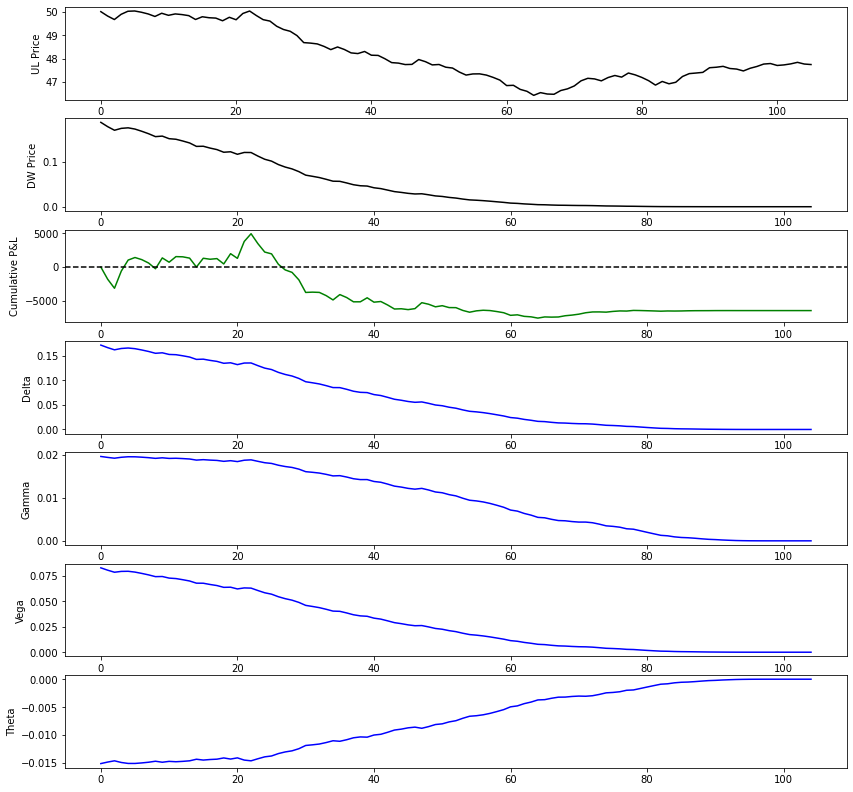

In [1037]:
ind = 0

fig, ax = plt.subplots(7, 1, figsize=(14,14))

ax[0].plot(St[:,ind], 'black')
ax[1].plot(DWPrice[:,ind], 'black')
ax[2].plot(AccPL[:,ind], color='g')
ax[3].plot(Delta[:,ind], color='b')
ax[4].plot(Gamma[:,ind], color='b')
ax[5].plot(Vega[:,ind], color='b')
ax[6].plot(Theta[:,ind], color='b')

ax[2].axhline(0, color='black', linestyle='dashed')

ax[0].set_ylabel('UL Price')
ax[1].set_ylabel('DW Price')
ax[2].set_ylabel('Cumulative P&L')
ax[3].set_ylabel('Delta')
ax[4].set_ylabel('Gamma')
ax[5].set_ylabel('Vega')
ax[6].set_ylabel('Theta')

plt.show()

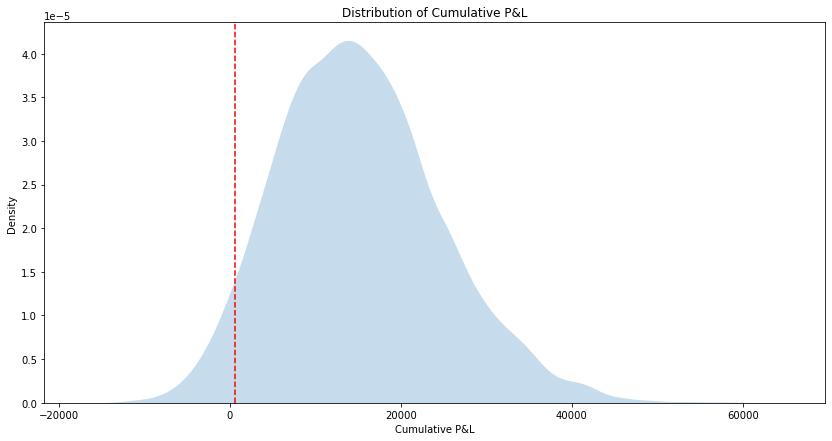

In [1038]:
plt.figure(figsize=(14,7))
ax = sns.kdeplot(data=AccPL[-1], fill=True, palette="crest", linewidth=0)

LowerP = np.percentile(AccPL[-1], 5)
alpha_ind = np.where(AccPL[-1] < LowerP)
cvar = AccPL[-1][alpha_ind].mean()

ax.axvline(LowerP, linestyle='dashed', color='red')

ax.set_xlabel('Cumulative P&L')
ax.set_title('Distribution of Cumulative P&L')
plt.show()

In [1039]:
LowerP

629.2936003336713

In [1040]:
cvar

-2281.3713765178813

In [1041]:
Return = AccPL[-1].mean()
Risk = abs(cvar)
sharpe = Return / Risk
sharpe

6.644415729151228

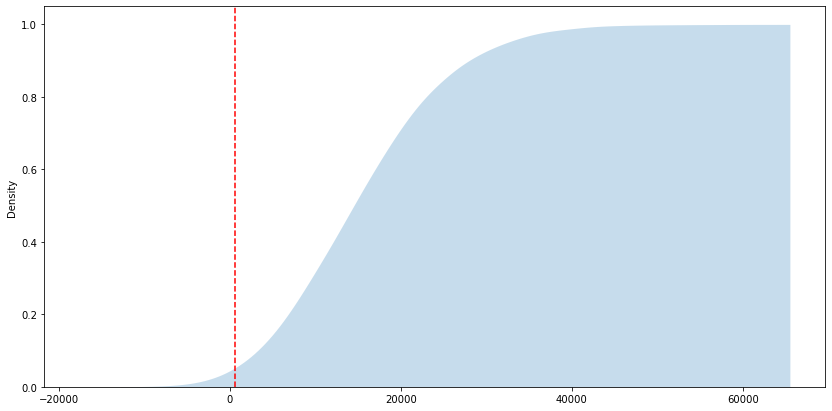

In [1042]:
plt.figure(figsize=(14,7))
ax = sns.kdeplot(data=AccPL[-1], cumulative=True, fill=True, palette="crest", linewidth=0)

ax.axvline(LowerP, linestyle='dashed', color='red')